In [2]:
import glob
import os
import random
from shutil import copyfile

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import matplotlib.cm as plt_cm
import matplotlib.colors as plt_colors
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

In [3]:
random.seed(1337)
random_state = 451
np.random.seed(42)

In [5]:
model_vgg16 = VGG16(weights='imagenet', include_top=True)
feat_extractor_vgg16 = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer("fc2").output)

In [6]:
def extract_img_data(img_path, dimension=224):
    img = image.load_img(img_path, target_size=(dimension, dimension))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    return img_data

In [7]:
def features_from_VGG16(img_data):
    img_data = preprocess_input(img_data)
    features = feat_extractor_vgg16.predict(img_data)[0]
    features = np.array(features)
    return features

In [8]:
def extract_features(image_list, method='vgg16', limit=1000):
    image_list_cleaned = []
    image_list = image_list[:limit]
    features_list = []
    for img_path in image_list:
        try:
            img_data = extract_img_data(img_path)
            if method == 'vgg16':
                features = features_from_VGG16(img_data)
            else:
                raise Exception('Unknown method')
        except:
            pass
        else:
            image_list_cleaned.append(img_path)
            features_list.append(features)
    return image_list_cleaned, features_list

In [9]:
def get_image_features(primary, secondary, method='vgg16', primary_limit=100, secondary_limit=1000):
    primary_image_list = glob.glob(primary)
    secondary_image_list = glob.glob(secondary)
    
    random.shuffle(primary_image_list)
    random.shuffle(secondary_image_list)
    
    image_list = []

    primary_list, primary_features = extract_features(primary_image_list, method, primary_limit)
          
    for img in primary_list:
          image_list.append({
              "path": img,
              "class": "primary",
          })
          
    secondary_list, secondary_features = extract_features(secondary_image_list, method, secondary_limit)
          
    for img in secondary_list:
          image_list.append({
              "path": img,
              "class": "secondary",
          })
            
    print("Found primary {} images, secondary {} images".format(len(primary_image_list),
                                                                len(secondary_image_list)))
          
    print("Cleaned primary: {}, Cleaned secondary: {}".format(len(primary_list),
                                                              len(secondary_list)))
          
    features = primary_features + secondary_features

    return np.array(features), image_list

In [10]:
def get_pca(features, n_components=30):
    pca = PCA(n_components=n_components)
    pca.fit(features)
    return pca.transform(features)

In [11]:
def get_tsne(features, tsne_dimensions=2, tsne_perplexity=10, tsne_learning_rate=150):
    tsne = TSNE(n_components=tsne_dimensions,
                learning_rate=tsne_learning_rate,
                perplexity=tsne_perplexity,
                verbose=0)
    return tsne.fit_transform(features)

In [12]:
def normalize_points(original_points, dimensions=2):
    points = []
    for i, f in enumerate(original_points):
        point = [float(
                (original_points[i, k] - np.min(original_points[:, k])) / 
                (np.max(original_points[:, k]) - np.min(original_points[:, k])
            )) for k in range(dimensions)]
        points.append(point)
    return np.array(points)

In [13]:
def make_collage(image_list, points, dimension=1000, primary_max_size=100, secondary_max_size=50):
    background_color = (255, 255, 255)
    img_collage = Image.new('RGB', (dimension, dimension), background_color)
    
    # Merge points and images
    data = []
    for i, image in enumerate(image_list):
        data.append({
            "image": image,
            "point": points[i],
        })
    
    def paste_to_collage(data_list, filter_name, max_size):
        filtered = [k for k in data_list if k["image"]["class"] == filter_name]
        for i, item in enumerate(filtered):
            img = Image.open(item["image"]["path"])
            img.thumbnail([max_size, max_size], Image.ANTIALIAS)
            x = int(item["point"][0] * dimension)
            y = int(item["point"][1] * dimension)
            img_collage.paste(img, (x, y))
            
    # Background and foreground
    paste_to_collage(data, "secondary", secondary_max_size)
    paste_to_collage(data, "primary", primary_max_size)

    return img_collage

In [14]:
def sort_by_point(image_list, points):
    data = []
    for i, point in enumerate(points):
        data.append({
            "image": image_list[i],
            "point": point[0],
        })
    return sorted(data, key=lambda item: item["point"])

In [15]:
def copy_to_folder(export_list, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for index, item in enumerate(export_list):
        filename = os.path.splitext(os.path.basename(item["image"]["path"]))[0]
        copyfile(item["image"]["path"], "{}/{}-{}.jpg".format(folder_path, (index + 1), filename))
    print("Copied {} files to '{}'".format(len(export_list), folder_path))

## 1.) GENERATE 2D COLLAGE

In [14]:
features_1, image_list_1 = get_image_features(primary='/users/adz/projects/zkm/dataset/original/**/*.jpg',
                                              secondary='/users/adz/projects/zkm/dataset/google/**/*.jpg',
                                              method='vgg16',
                                              primary_limit=100,
                                              secondary_limit=2500)

Found primary 48 images, secondary 2991 images
Cleaned primary: 48, Cleaned secondary: 2500


In [15]:
pca_1 = get_pca(features_1)
tsne_points_1 = get_tsne(pca_1, tsne_dimensions=2)
points_1 = normalize_points(tsne_points_1, dimensions=2)

In [16]:
img_1 = make_collage(image_list_1, points_1,
                     dimension=25000,
                     primary_max_size=2000,
                     secondary_max_size=500)

In [17]:
img_1.save("/users/adz/projects/zkm/export/set-collage-4-google.tiff",
           format="TIFF",
           compression="tiff_deflate")

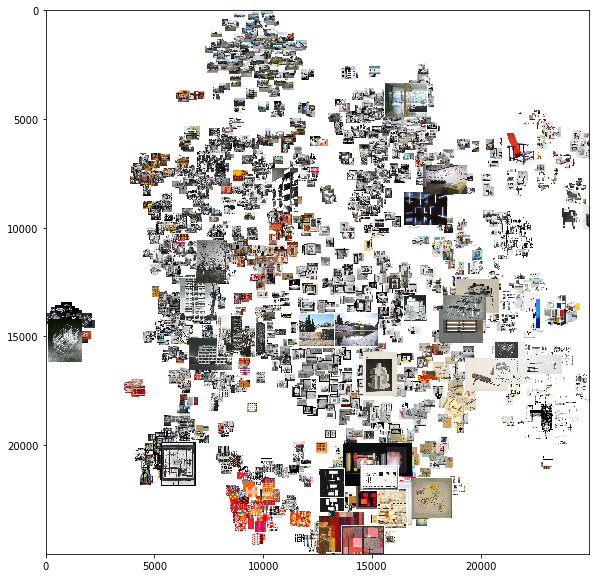

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(img_1, interpolation='nearest')

## 2.) SORT IMAGES (1D)

In [ ]:
features_2, image_list_2 = get_image_features(primary='/users/adz/projects/zkm/dataset/original/**/*.jpg',
                                              secondary='/users/adz/projects/zkm/dataset/google/**/*.jpg',
                                              method='vgg16',
                                              primary_limit=100,
                                              secondary_limit=500)

In [ ]:
pca_2 = get_pca(features_2)
tsne_points_2 = get_tsne(pca_2, tsne_dimensions=1)
points_2 = normalize_points(tsne_points_2, dimensions=1)
sorted_points_2 = sort_by_point(image_list_2, points_2)

In [ ]:
copy_to_folder(sorted_points_2,
               folder_path="/users/adz/projects/zkm/export/set-row-2")